# Mini-Challenge DLBS: Starberry Diesease detection
Bruno, FHNW, DLBS FS23

## About Data (3.1)
Data source: [Kaggle dataset](https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset)

There are a total of 2500 images with 1450 train images, 743 test images and 307 val images.

Dataset on seven types of Strawberry diesease with segmentation annotations:
- Angular Leafspot
- Anthracnose Fruit Rot
- Blossom Blight
- Gray Mold
- Leaf spot
- Powdery Mildew Fruit
- Powdery Mildew Leaf

![Strawberry-disease-image](../media/Strawberry-disease-image.png)
Reference: https://www.mdpi.com/1424-8220/21/19/6565

The data is of high quality which makes prediction much easier. While for some classes it doesn't have a lot of data (89 training samples for the least occurring class), it achieves a fairly even score in the baseline Mask R-CNN for most classes. The problem with some classes doesn't seem to stem only from a lack of data. During a manual evaluation of the data (this can also be done using Roboflow and the dataset uploaded there: https://universe.roboflow.com/dlbs-zcxsj/strawberry-hxgaj), the data seems to be mostly close-ups of the diseases themselves which also makes prediction much easier and we don't need to find ways to improve prediction since the background doesn't get in the way. Leaves can overlap with other leaves though and some pcitures have multiple fruits for example but most of them have very similar diseases/classes so the model doesn't need to predict a thousand different classes per image which is also an advantage of this dataset. If we want to use it in production, the model only works on the same type of data. So someone who wants to identify diseases should also take close up photos of the plant.

The RGB channel value distribution at the end of this notebook highlights the colors of the data set. It shows how the most frequent color is green with red being the close second. This is obviously due to the leaves green color and the strawberries red fruit color. Blue is not so represented in the data but we can see a small spike in the 255 value which can mean some parts were the image is black. 

The dataset was also collected from multiple greenhouses udner natural illumination conditions in South Korea and verified by experts in the field. 20% of the dataset is from different online sources but it is assumed that the 20% has also been verified and is of high quality. One interesting aspect is that diseases can be in initial, middle or final stages. Initial stages might be hard to detect while all phases might have big color differences.

## Imports

In [1]:
import glob
import glob
import random
import json

import pandas as pd

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

## Data Inspection

Strawberry data is available in 'train', 'test' and 'val' folders. Annotations per image are also available in the same folder as json file. Under 'shapes', labels and points contain the name of disease and the points to form the polygon

- `data_dir_<train>/<test>/<val>` define the location of the dataset used as train, val and test set.


### Load data 

In [2]:
import os

data_dir_test = os.path.join('../strawberry', 'test')
data_dir_train = os.path.join('../strawberry', 'train')
data_dir_val = os.path.join('../strawberry', 'val')
os.path.isdir(data_dir_test)

True

In [3]:
# Extract train, test, val images and labels

def load_data(data_dir, n=-1):
    images = [] 
    labels = {} # to capture image name as key and corresponding label out of json as value
    points = {}
    
    elems = glob.glob(os.path.join(data_dir, '*.jpg'))
    elems = sorted(elems)
    
    i = 0
    for elem in tqdm(elems):
        # Read image
        img = Image.open(elem)
        images.append(img)
    
        # Read label path
        label_path = elem.lower().replace('jpg','json')
    
        # Read labels from json file
        f = open(label_path)
        label_data = json.load(f)
        
        image_labels = []
        image_points = []
        for shapes in label_data['shapes']:
            label = shapes['label']
            point = shapes['points']
            image_labels.append(label)
            image_points.append(point)

        labels[label_data['imagePath']] = image_labels
        points[label_data['imagePath']] = image_points
        
        #for testing with smaller data volume
        if n != -1:
            if i == n:
                break
        i+=1
        
    df = pd.DataFrame(list(labels.items()), columns=["image", "label"])
    df_points = pd.DataFrame(list(points.items()), columns=["image", "points"])
    df = df.merge(df_points, on="image")
        
    return images, df

In [4]:
# loading train images and train_labels
train_images, df_train_labels = load_data(data_dir_train)
test_images, df_test_labels = load_data(data_dir_test)
val_images, df_val_labels = load_data(data_dir_val)

100%|██████████| 307/307 [00:00<00:00, 3378.00it/s]


### Analyze data quantitatively

Analyze the images and labels such as

- number of images
- image shape and count
- Images per disease class
- Imbalance if any
- Bias if any


#### Count of images

There are in total 2500 images with 1450 for training, 307 as validation and 743 as test images

In [5]:
print(f'Count of train images: {len(train_images)}')
print(f'Count of test images: {len(test_images)}')
print(f'Count of val images: {len(val_images)}')

Count of train images: 1450
Count of test images: 743
Count of val images: 307


#### Image shape and count

It seems that all images are of same shape : (419,419) with RGB color channel

In [6]:
np.array(train_images[0]).shape

(419, 419, 3)

In [7]:
train_shapes = []
for image in train_images:
    train_shapes.append(np.array(image).shape)
    
test_shapes = []
for image in test_images:
    test_shapes.append(np.array(image).shape)
    
val_shapes = []
for image in val_images:
    val_shapes.append(np.array(image).shape)

In [8]:
print(set(train_shapes))
print(set(test_shapes))
print(set(val_shapes))

{(419, 419, 3)}
{(419, 419, 3)}
{(419, 419, 3)}


#### Images by disease class

There are images on seven types of strawberry diseases.
- In training set, not all disease classes are represented equally.
- 

In [11]:
df_train_labels

,image,label,points
0,angular_leafspot1.jpg,"[Angular Leafspot, Angular Leafspot, Angular L...","[[[86.68965517241381, 261.2068965517241], [81...."
1,angular_leafspot10.jpg,"[Angular Leafspot, Angular Leafspot, Angular L...","[[[332.3793103448276, 226.29310344827587], [31..."
2,angular_leafspot100.jpg,[Angular Leafspot],"[[[417.72413793103453, 124.13793103448276], [4..."
3,angular_leafspot101.jpg,[Angular Leafspot],"[[[416.4310344827586, 64.65517241379311], [299..."
4,angular_leafspot102.jpg,[Angular Leafspot],"[[[119.01724137931035, 145.25862068965517], [1..."
...,...,...,...
1445,powdery_mildew_leaf95.jpg,"[Powdery Mildew Leaf, Powdery Mildew Leaf, Pow...","[[[189.24137931034483, 343.1034482758621], [19..."
1446,powdery_mildew_leaf96.jpg,"[Powdery Mildew Leaf, Powdery Mildew Leaf, Pow...","[[[337.51724137931035, 1.7241379310344829], [3..."
1447,powdery_mildew_leaf97.jpg,"[Powdery Mildew Leaf, Powdery Mildew Leaf, Pow...","[[[239.6724137931035, 190.08620689655174], [24..."
1448,powdery_mildew_leaf98.jpg,"[Powdery Mildew Leaf, Powdery Mildew Leaf, Pow...","[[[258.6379310344828, 308.62068965517244], [26..."


Text(0.5, 1.0, 'Training Images by Strawberry disease class')

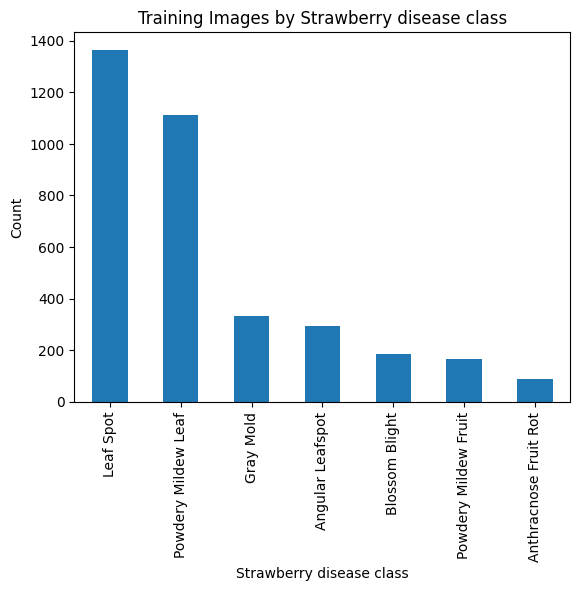

In [12]:
df_train_labels_ = df_train_labels.explode('label')
df_train_labels_.groupby('label').image.size().sort_values(ascending=False).plot.bar()
plt.xlabel('Strawberry disease class')
plt.ylabel('Count')
plt.title('Training Images by Strawberry disease class')


In [13]:
df_train_labels_.groupby('label').image.size().sort_values(ascending=False)

label
Leaf Spot                1365
Powdery Mildew Leaf      1110
Gray Mold                 332
Angular Leafspot          294
Blossom Blight            186
Powdery Mildew Fruit      164
Anthracnose Fruit Rot      89
Name: image, dtype: int64

Text(0.5, 1.0, 'Training Images by Strawberry disease class')

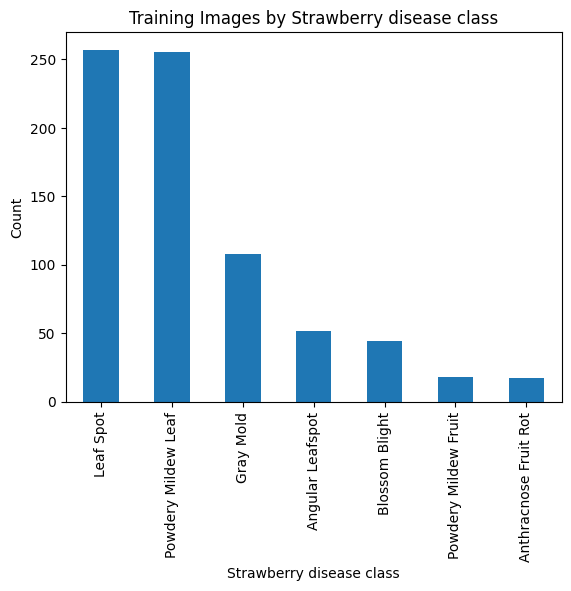

In [14]:
df_val_labels_ = df_val_labels.explode('label')
df_val_labels_.groupby('label').image.size().sort_values(ascending=False).plot.bar()
plt.xlabel('Strawberry disease class')
plt.ylabel('Count')
plt.title('Training Images by Strawberry disease class')

Text(0.5, 1.0, 'Training Images by Strawberry disease class')

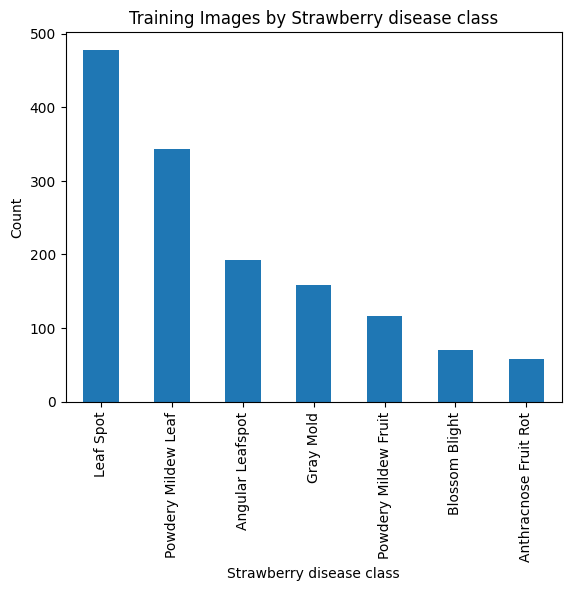

In [15]:
df_test_labels_ = df_test_labels.explode('label')
df_test_labels_.groupby('label').image.size().sort_values(ascending=False).plot.bar()
plt.xlabel('Strawberry disease class')
plt.ylabel('Count')
plt.title('Training Images by Strawberry disease class')

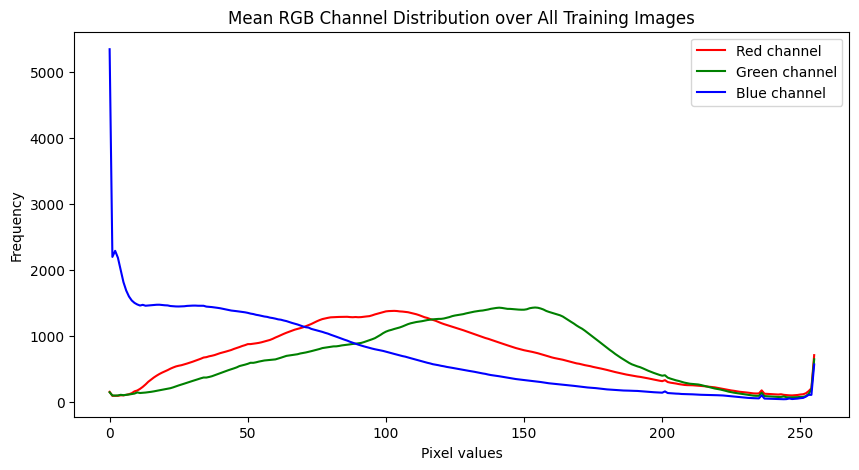

In [20]:
def accumulate_histograms(df):
    # Initialize sum of histograms
    sum_hist_red = np.zeros(256)
    sum_hist_green = np.zeros(256)
    sum_hist_blue = np.zeros(256)
    num_images = 0

    for image_path in df['image']:
        image = Image.open("../strawberry/train/" + image_path)
        image_arr = np.array(image)

        red_channel = image_arr[:,:,0]
        green_channel = image_arr[:,:,1]
        blue_channel = image_arr[:,:,2]

        # Accumulate histograms
        sum_hist_red += np.histogram(red_channel.ravel(), bins=256, range=(0,256))[0]
        sum_hist_green += np.histogram(green_channel.ravel(), bins=256, range=(0,256))[0]
        sum_hist_blue += np.histogram(blue_channel.ravel(), bins=256, range=(0,256))[0]

        num_images += 1

    # Calculate mean histograms
    mean_hist_red = sum_hist_red / num_images
    mean_hist_green = sum_hist_green / num_images
    mean_hist_blue = sum_hist_blue / num_images

    return mean_hist_red, mean_hist_green, mean_hist_blue

def plot_mean_histograms(mean_hist_red, mean_hist_green, mean_hist_blue):
    plt.figure(figsize=(10, 5))

    plt.plot(mean_hist_red, color='red', label='Red channel')
    plt.plot(mean_hist_green, color='green', label='Green channel')
    plt.plot(mean_hist_blue, color='blue', label='Blue channel')

    plt.legend()
    plt.xlabel('Pixel values')
    plt.ylabel('Frequency')
    plt.title('Mean RGB Channel Distribution over All Training Images')
    plt.show()

# Calculate mean histograms over all images
mean_hist_red, mean_hist_green, mean_hist_blue = accumulate_histograms(df_train_labels)

# Plot mean histograms
plot_mean_histograms(mean_hist_red, mean_hist_green, mean_hist_blue)

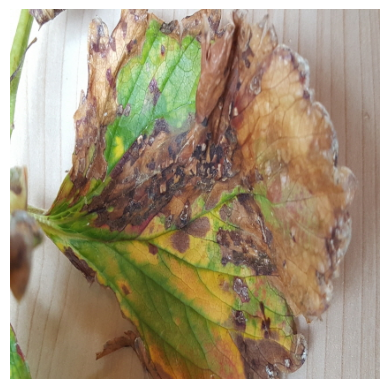

Image size:  (419, 419, 3)
Disease label for image angular_leafspot20.jpg is Angular Leafspot


In [12]:
### BEGIN SOLUTION
num = 50  #index num image
### END SOLUTION
plot_functions.plot_image(train_images[num])
print('Image size: ', train_images[num].shape)
print(f'Disease label for image {df_train_labels["image"][num]} is {df_train_labels["label"][num]}')